<a href="https://colab.research.google.com/github/mafaldasalomao/pavic_treinamento_ml/blob/main/PAVIC_ML_12_PT_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. PyTorch Transfer Learning



## 0. Configuração do ambiente

> **Observação:** desde junho de 2022, este notebook usa as versões nightly  de `torch` e `torchvision`, pois `torchvision` v0.13+ é necessário para usar a API de pesos múltiplos atualizada. Você pode instalá-los usando o comando abaixo.

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 109.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 78.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 80.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/10

torch version: 2.0.0+cu118
torchvision version: 0.15.1+cu118


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mafaldasalomao/pavic_treinamento_ml.git
    !mv pavic_treinamento_ml/going_modular .
    !rm -rf pavic_treinamento_ml
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pavic_treinamento_ml'...
remote: Enumerating objects: 507, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 507 (delta 63), reused 121 (delta 49), pack-reused 367
Receiving objects: 100% (507/507), 81.36 MiB | 39.65 MiB/s, done.
Resolving deltas: 100% (271/271), done.


In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data

Before we can start to use **transfer learning**, we'll need a dataset.

vamos usar transfer learning para usar no nosso dataset FoodVision

Vamos escrever um codigo para baixar o dataset [`pizza_steak_sushi.zip`](https://github.com/mafaldasalomao/pavic_treinamento_ml/raw/main/data/pizza_steak_sushi.zip) que está disponivel no github


In [4]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mafaldasalomao/pavic_treinamento_ml/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


Vamos criar os diretórios de train e test

In [5]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Criação de Datasets e DataLoaders

Como baixamos o diretório `going_modular`, podemos usar o script que criamos na seção anterior para preparar e configurar nossos DataLoaders.

Mas como usaremos um modelo pré-treinado de `torchvision.models`, há uma transformação específica que precisamos para preparar nossas imagens primeiro.

### 2.1 Creating a transform for `torchvision.models` (manual creation)

> **Important:** Para você testar seus dados com um modelo já existente e já treinado com outro dataset precisamos fazer alguns processamentos que os dados do dataset original tiveram! Caso contrário, o modelo não irá performar tão bem


Antes do `torchvision` v0.13+, para criar um transform para u modelo `torchvision.models`, a documentação era:

> Todos modelos pre-treinados esperavam na entrada imagens normalizadas de alhima maneira, como mini-batches de 3 canais RGB (3 x H x W), onde H e W são esperados ser pelo menos 224. 
>
> As imagens eram carregadas no range de `[0, 1]` e normalizadas utilizando `mean = [0.485, 0.456, 0.406]` e `std = [0.229, 0.224, 0.225]`. 
>
> Voce pode utilizar o seguinte transform para normalizar:
>
> ```
> normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
>                                  std=[0.229, 0.224, 0.225])
> ```

Além dessas transformações, ao mesmo tempo voce poderia também: 

| **Transform number** | **Transform required** | **Code to perform transform** | 
| ----- | ----- | ----- |
| 1 | Mini-batches of size `[batch_size, 3, height, width]` where height and width are at least 224x224^. | `torchvision.transforms.Resize()` to resize images into `[3, 224, 224]`^ and `torch.utils.data.DataLoader()` to create batches of images. |
| 2 | Values between 0 & 1. | `torchvision.transforms.ToTensor()` |
| 3 | A mean of `[0.485, 0.456, 0.406]` (values across each colour channel). | `torchvision.transforms.Normalize(mean=...)` to adjust the mean of our images.  |
| 4 | A standard deviation of `[0.229, 0.224, 0.225]` (values across each colour channel). | `torchvision.transforms.Normalize(std=...)` to adjust the standard deviation of our images.  | 

> **Note:** Alguns modelos pre-treinado seguiam  `torchvision.models` em diferentes shapes de `[3, 224, 224]`, por exemplo, o formato `[3, 240, 240]`. Para este tipo de entrada check a documentação

> **Pergunta:** *De onde vieram os valores de média e desvio padrão? Por que precisamos fazer isso?*
>
> Estes foram calculados a partir dos dados. Especificamente, o conjunto de dados ImageNet tomando as médias e desvios padrão em um subconjunto de imagens.
>
> Nós também não *precisamos* fazer isso. As redes neurais geralmente são capazes de descobrir distribuições de dados apropriadas (elas calculam onde a média e os desvios padrão precisam estar por conta própria), mas defini-las no início pode ajudar nossas redes a obter um melhor desempenho mais rapidamente.

Vamos compor uma série de `torchvision.transforms` para executar as etapas acima.

In [6]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

Agora nos podemos criar nossos dataloaders como o `create_dataloaders` função criada no `dataset_setup.py` do notebook anterior

Vamos deixar o `batch_size=32` nosso modelo verá 32 registros por vez.

e usaremos nosso transform para carregar nosso dataset `transform=manual_transform`.

> **Observação:** incluí esta criação manual de transformações neste notebook porque você pode encontrar recursos que usam este estilo. Também é importante observar que, como essas transformações são criadas manualmente, elas também são infinitamente personalizáveis. Portanto, se você quiser incluir técnicas de aumento de dados em seu pipeline de transformações, poderá fazê-lo.

In [7]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f41363cb310>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for `torchvision.models` (auto creation)
No `torchvision` v0.13+, uma criação automática de tranform foi adicionada .


Quando configurar um modelo do `torchvision.models` e selecionar um modelo pre-treinado.
    
```python
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
```

Onde,
* `EfficientNet_B0_Weights` é a arquitetura do modelo com pesos e nós gostaríamos de usar diferentes opções de arquitetura no `torchvision.models`.
* `DEFAULT` significa o *best available* pesos (melhor performance do ImageNet).


In [8]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

E agora para acessar as transformações associadas aos nossos `pesos`, podemos usar o método `transforms()`.

Isso significa essencialmente "obter as transformações de dados que foram usadas para treinar o `EfficientNet_B0_Weights` no ImageNet".

In [9]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

Observe como `auto_transforms` é muito semelhante a `manual_transforms`, a única diferença é que `auto_transforms` veio com a arquitetura do modelo que escolhemos, onde tivemos que criar `manual_transforms` manualmente.

O benefício de criar automaticamente uma transformação por meio de `weights.transforms()` é que você garante que está usando a mesma transformação de dados que o modelo pré-treinado usado quando foi treinado.

No entanto, a desvantagem de usar transformações criadas automaticamente é a falta de personalização.

Podemos usar `auto_transforms` para criar DataLoaders com `create_dataloaders()` assim como antes.

In [10]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f41363ca800>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

A ideia do aprendizado por transferência é **pegar um modelo já de bom desempenho em um espaço de problemas semelhante ao seu e personalizá-lo para o seu caso de uso**.

Explorando a documentação, você encontrará muitos backbones comuns de arquitetura de visão computacional, como:

| **Architecuture backbone** | **Code** |
| ----- | ----- |
| [ResNet](https://arxiv.org/abs/1512.03385)'s | `torchvision.models.resnet18()`, `torchvision.models.resnet50()`... | 
| [VGG](https://arxiv.org/abs/1409.1556) (similar to what we used for TinyVGG) | `torchvision.models.vgg16()` | 
| [EfficientNet](https://arxiv.org/abs/1905.11946)'s | `torchvision.models.efficientnet_b0()`, `torchvision.models.efficientnet_b1()`... | 
| [VisionTransformer](https://arxiv.org/abs/2010.11929) (ViT's)| `torchvision.models.vit_b_16()`, `torchvision.models.vit_b_32()`... | 
| [ConvNeXt](https://arxiv.org/abs/2201.03545) | `torchvision.models.convnext_tiny()`,  `torchvision.models.convnext_small()`... |
| More available in `torchvision.models` | `torchvision.models...` | 

### 3.1 QUal modelo pre-treinado escolher?

Depende do seu dispositivo e problema

Geralmente, o número mais alto no nome do modelo (por exemplo, `eficientenet_b0()` -> `eficientenet_b1()` -> `eficientenet_b7()`) significa *melhor desempenho*, mas um modelo *maior*.

Você pode pensar que melhor desempenho é *sempre melhor*, certo?

Isso é verdade, mas **alguns modelos de melhor desempenho são grandes demais para alguns dispositivos**.

Por exemplo, digamos que você gostaria de executar seu modelo em um dispositivo móvel, você terá que levar em consideração os recursos de computação limitados no dispositivo, portanto, você estaria procurando por um modelo menor.

Mas se você tem poder computacional ilimitado, como afirma [*The Bitter Lesson*](http://www.incompleteideas.net/IncIdeas/BitterLesson.html), você provavelmente pegaria o maior e mais exigente modelo computacional que você pode.

Entender essa **compensação de desempenho x velocidade x tamanho** virá com o tempo e a prática.

Para mim, encontrei um bom equilíbrio nos modelos `eficientenet_bX`.


### 3.2 Configurando um modelo pre-treinado



In [11]:
# OLD: Setup the model with pretrained weights and send it to the target device (this was prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD method (with pretrained=True)

# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

#model # uncomment to output (it's very long)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 117MB/s] 


> **Note:** In previous versions of `torchvision`, you'd create a prertained model with code like:
>
> `model = torchvision.models.efficientnet_b0(pretrained=True).to(device)`
>
> However, running this using `torchvision` v0.13+ will result in errors such as the following:
> 
> `UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.`
>
> And...
> 
> `UserWarning: Arguments other than a weight enum or None for weights are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing weights=EfficientNet_B0_Weights.IMAGENET1K_V1. You can also use weights=EfficientNet_B0_Weights.DEFAULT to get the most up-to-date weights.`

### 3.3 Olhando mais informações com o summary do nosso modelo `torchinfo.summary()`

Para saber mais sobre nosso modelo, vamos usar o método [`summary()`] do `torchinfo` (https://github.com/TylerYep/torchinfo#documentation).

Para isso, vamos passar:
  * `model` - o modelo do qual gostaríamos de obter um resumo.
  * `input_size` - a forma dos dados que gostaríamos de passar para o nosso modelo, para o caso de `functionalnet_b0`, o tamanho de entrada é `(batch_size, 3, 224, 224)`, embora [outras variantes de ` eficientenet_bX` têm diferentes tamanhos de entrada](https://github.com/pytorch/vision/blob/d2bfd639e46e1c5dc3c177f889dc7750c8d137c7/references/classification/train.py#L92-L93).
     * **Observação:** muitos modelos modernos podem lidar com imagens de entrada de tamanhos variados graças a [`torch.nn.AdaptiveAvgPool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html), esta camada ajusta de forma adaptativa o `output_size` de uma determinada entrada conforme necessário. Você pode tentar isso passando imagens de entrada de tamanhos diferentes para `summary()` ou seus modelos.
  * `col_names` - as várias colunas de informações que gostaríamos de ver sobre nosso modelo.
  * `col_width` - a largura das colunas para o resumo.
  * `row_settings` - quais recursos mostrar em uma linha.

In [12]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

/usr/local/lib/python3.10/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.10/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

### 3.4 Congelando o modelo base e alterando a camada de saída para atender às nossas necessidades

TPara congelar algumas camadas/parametros nas seções de `features` 
 basta configurar o `requires_grad=False`.

Para parâmetros com `requires_grad=False`, o PyTorch não rastreia as atualizações de gradiente e, por sua vez, esses parâmetros não serão alterados pelo nosso otimizador durante o treinamento.

Em essência, um parâmetro com `requires_grad=False` é "incapaz de treinar" ou "congelado" no local.

In [13]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

Vamos agora ajustar a camada de saída ou a parte `classifier` de nosso modelo pré-treinado para nossas necessidades.

No momento, nosso modelo pré-treinado tem `out_features=1000` porque existem 1000 classes no ImageNet.

No entanto, não temos 1000 classes, temos apenas três, pizza, bife e sushi.

Podemos alterar a parte `classifier` do nosso modelo criando uma nova série de camadas.

O `classificador` atual consiste em:

```
(classificador): Sequencial(
     (0): Dropout(p=0,2, inplace=True)
     (1): Linear(in_features=1280, out_features=1000, bias=True)
```

Manteremos a camada `Dropout` da mesma forma 



E manteremos `in_features=1280` para nossa camada de saída `Linear`, mas alteraremos o valor `out_features` para o comprimento de nossos `class_names` (`len(['pizza', 'steak', 'sushi ']) = 3`).

Nossa nova camada `classifier` deve estar no mesmo dispositivo que nosso `model`.

In [14]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

Legal!

Camada de saída atualizada, vamos obter outro resumo do nosso modelo e ver o que mudou.

In [15]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

* **Menos parâmetros treináveis** - Anteriormente havia 5.288.548 parâmetros treináveis. Mas como congelamos muitas das camadas do modelo e deixamos apenas o 'classificador' como treinável, agora existem apenas 3.843 parâmetros treináveis (ainda menos que nosso modelo TinyVGG). Embora também haja 4.007.548 parâmetros não treináveis, eles criarão uma representação básica de nossas imagens de entrada para alimentar nossa camada `classificador`.

> **Observação:** quanto mais parâmetros treináveis um modelo tiver, mais poder de computação/mais tempo levará para treinar. Congelar as camadas base do nosso modelo e deixá-lo com menos parâmetros treináveis significa que nosso modelo deve treinar bem rápido. Esse é um grande benefício do aprendizado por transferência, pegando os parâmetros já aprendidos de um modelo treinado em um problema semelhante ao seu e apenas ajustando ligeiramente as saídas para se adequar ao seu problema.

## 4. Train model

Para começar o treinamento, vamos criar uma função de perda e um otimizador.

Como ainda estamos trabalhando com classificação multiclasse, usaremos `nn.CrossEntropyLoss()` para a função de perda.

E continuaremos com `torch.optim.Adam()` como nosso otimizador com `lr=0.001`.


In [16]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0929 | train_acc: 0.4023 | test_loss: 0.9125 | test_acc: 0.5502
Epoch: 2 | train_loss: 0.8703 | train_acc: 0.7773 | test_loss: 0.7900 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.8008 | test_loss: 0.7433 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7114 | train_acc: 0.7578 | test_loss: 0.6344 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6252 | train_acc: 0.7930 | test_loss: 0.6238 | test_acc: 0.8864
[INFO] Total training time: 17.257 seconds


## 5. Evaluate model by plotting loss curves


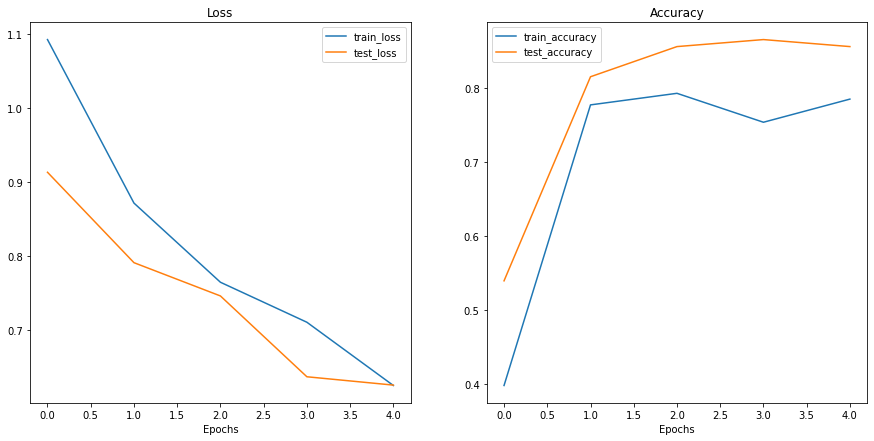

In [ ]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

## 6. Faça previsões em imagens do conjunto de teste

Parece que nosso modelo funciona bem quantitativamente, mas e qualitativamente?

Vamos descobrir fazendo algumas previsões com nosso modelo em imagens do conjunto de teste (elas não são vistas durante o treinamento) e plotando-as.

*Visualize, visualize, visualize!*

Uma coisa que devemos lembrar é que, para nosso modelo fazer previsões sobre uma imagem, a imagem deve estar no *mesmo* formato das imagens nas quais nosso modelo foi treinado.

Isso significa que precisaremos garantir que nossas imagens tenham:
* **Mesma forma** - Se nossas imagens tiverem formas diferentes daquelas em que nosso modelo foi treinado, obteremos erros de forma.
* **Mesmo tipo de dados** - Se nossas imagens forem um tipo de dados diferente (por exemplo, `torch.int8` vs. `torch.float32`), obteremos erros de tipo de dados.
* **Mesmo dispositivo** - Se nossas imagens estiverem em um dispositivo diferente do nosso modelo, obteremos erros de dispositivo.
* **Mesmas transformações** - Se nosso modelo for treinado em imagens que foram transformadas de uma determinada maneira (por exemplo, normalizadas com uma média e desvio padrão específicos) e tentarmos fazer previsões sobre imagens transformadas de uma maneira diferente, essas previsões podem estar fora.

> **Observação:** esses requisitos valem para todos os tipos de dados se você estiver tentando fazer previsões com um modelo treinado. Os dados que você gostaria de prever devem estar no mesmo formato em que seu modelo foi treinado.

Para fazer tudo isso, criaremos uma função `pred_and_plot_image()` para:

1. Pegue um modelo treinado, uma lista de nomes de classes, um caminho de arquivo para uma imagem de destino, um tamanho de imagem, uma transformação e um dispositivo de destino.
2. Abra uma imagem com [`PIL.Image.open()`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.open).
3. Crie uma transformação para a imagem (o padrão será `manual_transforms` que criamos acima ou pode usar uma transformação gerada a partir de `weights.transforms()`).
4. Certifique-se de que o modelo esteja no dispositivo de destino.
5. Ative o modo de avaliação do modelo com `model.eval()` (isso desativa camadas como `nn.Dropout()`, para que não sejam usadas para inferência) e o gerenciador de contexto do modo de inferência.
6. Transforme a imagem de destino com a transformação feita na etapa 3 e adicione uma dimensão de lote extra com `torch.unsqueeze(dim=0)` para que nossa imagem de entrada tenha a forma `[batch_size, color_channels, height, width]`.
7. Faça uma previsão na imagem passando-a para o modelo, garantindo que ela esteja no dispositivo de destino.
8. Converta os logits de saída do modelo em probabilidades de predição com `torch.softmax()`.
9. Converta as probabilidades de predição do modelo em rótulos de predição com `torch.argmax()`.
10. Plote a imagem com `matplotlib` e defina o título para o rótulo de previsão da etapa 9 e a probabilidade de previsão da etapa 8.

> **Nota:** Esta é uma função semelhante a [04. PyTorch Custom Datasets section 11.3's](https://www.learnpytorch.io/04_pytorch_custom_datasets/#113-putting-custom-image-prediction-together-building-a-function) `pred_and_plot_image()` com algumas etapas ajustadas .

In [19]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

Que função bonita!

Vamos testá-lo fazendo previsões sobre algumas imagens aleatórias do conjunto de teste.

Podemos obter uma lista de todos os caminhos de imagem de teste usando `list(Path(test_dir).glob("*/*.jpg"))`, as estrelas no método `glob()` dizem "qualquer arquivo que corresponda a este padrão ", ou seja, qualquer arquivo que termine em `.jpg` (todas as nossas imagens).

E então podemos amostrar aleatoriamente um número deles usando [`random.sample(populuation, k)`](https://docs.python.org/3/library/random.html#random.sample) do Python onde `population ` é a sequência a ser amostrada e `k` é o número de amostras a serem recuperadas.

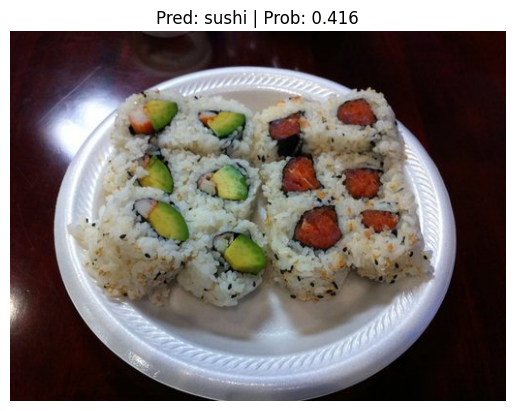

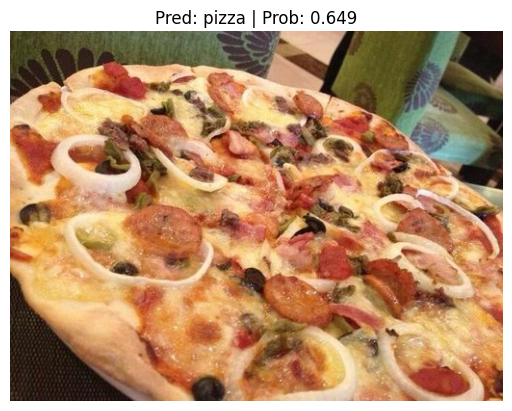

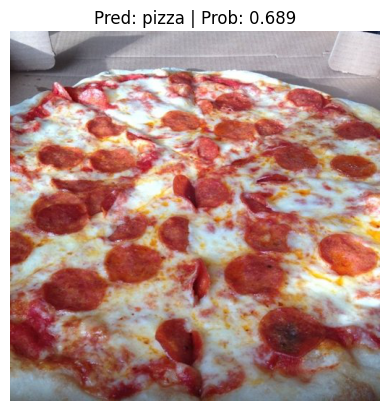

In [20]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

### 6.1 Fazendo previsões em uma imagem personalizada

Parece que nosso modelo se sai bem qualitativamente nos dados do conjunto de teste.

Mas que tal em nossa própria imagem personalizada?

É aí que está a verdadeira diversão do aprendizado de máquina!

Prevendo com base em seus próprios dados personalizados, fora de qualquer conjunto de treinamento ou teste.

Para testar nosso modelo em uma imagem personalizada, vamos importar a antiga e fiel imagem `pizza-dad.jpeg` (uma imagem do meu pai comendo pizza).

Vamos então passá-lo para a função `pred_and_plot_image()` que criamos acima e ver o que acontece.

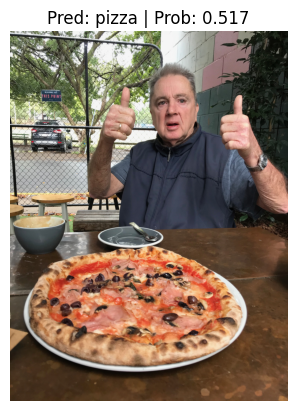

In [27]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://github.com/mafaldasalomao/pavic_treinamento_ml/blob/main/data/04-pizza-dad.jpeg?raw=true")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)